# Introdução
Este estudo analisa o crescimento da população do Brasil com base em dados históricos. Para isso, são comparados dois modelos matemáticos baseados em equações diferenciais: o modelo Exponencial de Malthus, que prevê um crescimento contínuo, e o modelo Logístico de Verhulst, que considera que a população se estabiliza ao atingir um limite. A análise inclui o ajuste de cada modelo aos dados, a medição de seus erros para determinar qual é o mais preciso e, por fim, a utilização do modelo vencedor para projetar a população até o ano de 2050. Ao final, o resultado dessa projeção é comparado com dados divulgados pela ONU para avaliar a eficácia do estudo.

Os dados históricos que servem como base para esta análise foram obtidos a partir da plataforma Our World in Data.

#Montando o Notebook no Google Drive para importar a Base

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/MyDrive/

Mounted at /content/drive/
/content/drive/MyDrive


# Importando as bibliotecas usadas para a análise

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score, mean_squared_error

# Carregando e tratando a base de dados para a análise

In [4]:
data = pd.read_csv("population.csv")
display(data)

,Entity,Year,all years
0,Afghanistan,1950,7776133
1,Afghanistan,1951,7879295
2,Afghanistan,1952,7987737
3,Afghanistan,1953,8096656
4,Afghanistan,1954,8207910
...,...,...,...
18939,Zimbabwe,2019,15271330
18940,Zimbabwe,2020,15526837
18941,Zimbabwe,2021,15797165
18942,Zimbabwe,2022,16069010


In [5]:
data = data.rename(columns={'Entity': 'pais', 'Year': 'ano', 'all years':'populacao'})
display(data)

,pais,ano,populacao
0,Afghanistan,1950,7776133
1,Afghanistan,1951,7879295
2,Afghanistan,1952,7987737
3,Afghanistan,1953,8096656
4,Afghanistan,1954,8207910
...,...,...,...
18939,Zimbabwe,2019,15271330
18940,Zimbabwe,2020,15526837
18941,Zimbabwe,2021,15797165
18942,Zimbabwe,2022,16069010


In [6]:
dados_brasil = data[data['pais'] == 'Brazil']
display(dados_brasil)

,pais,ano,populacao
2294,Brazil,1950,53408501
2295,Brazil,1951,55018796
2296,Brazil,1952,56694832
2297,Brazil,1953,58433700
2298,Brazil,1954,60235068
...,...,...,...
2363,Brazil,2019,207455405
2364,Brazil,2020,208660785
2365,Brazil,2021,209550238
2366,Brazil,2022,210306358


In [7]:
# Garatindo que os anos estejam ordenados cronológicamente
dados_brasil = dados_brasil.sort_values('ano')

# Transformando os dados do DataFrame para arrays do NumPy
anos = dados_brasil['ano'].to_numpy()
populacao_real = dados_brasil['populacao'].to_numpy()

# Definição do modelo:
Existem diferentes modelos de equações diferenciais que podem ser utilizados para representar o crescimento de uma população. Neste estudo, serão comparados dois modelos clássicos: o Modelo Exponencial de Malthus, que assume crescimento ilimitado, e o Modelo Logístico de Verhulst, que considera a existência de um limite ambiental (capacidade de suporte).

#Modelo Exponencial de Malthus

A equação diferencial que modela o crescimento populacional exponencial é dada por:

$$
\frac{dP}{dt} = kP
$$

Onde:
 * $ \frac{dP}{dt} $ é a derivada da função que modela a população $P(t)$ em relação ao tempo $t$, ou seja, representa a taxa de variação da população ao longo do tempo
 * $k$ é a taxa de crescimento populacional
 * $P$ é a população no instante $t$


# Solução da equação diferencial:

$$
P(t) = P_0 e^{kt}
$$

Onde:
- $P_0$ é a população inicial no tempo $t = 0$.


In [8]:
# Definindo a função que modela a população em um instante de tempo (t)
def modelo_malthus(t, k, populacao_inicial):
    return populacao_inicial * np.exp(k * (t - t.min()))

In [9]:
# Para definir a tava de crescimento k, foi usada a função curve_fit() para estimar esse paramêtro
# O paramêtro P0 foi retirado diretamente do DataFrame, sendo ele a população inicial
parametros, _ = curve_fit(lambda t, k: modelo_malthus(t, k, populacao_real[0]), anos, populacao_real, p0=[0.01])
k_estimado = parametros[0]
populacao_inicial = populacao_real[0]

print(f'Taxa de crescimento estimada (k): {k_estimado:.5f}')
print(f'População inicial (P0): {populacao_inicial}')

Taxa de crescimento estimada (k): 0.02126
População inicial (P0): 53408501


In [10]:
# Fazendo a previsão usando o paramêtro k estimado e os dados retirados do DataFrame
populacao_malthus = modelo_malthus(anos, k_estimado, populacao_inicial)

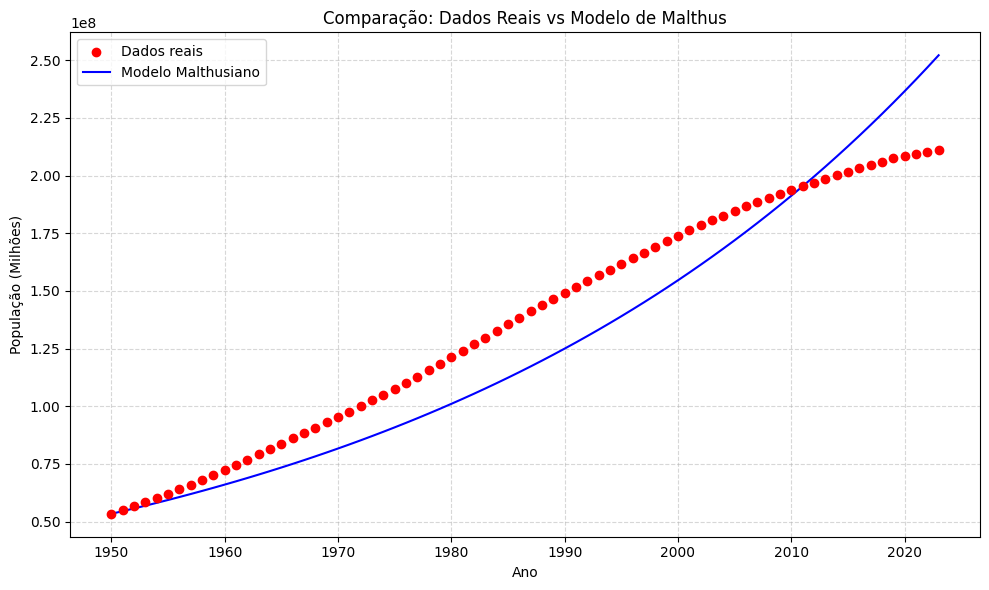

In [11]:
# Plotando os dados reais e o modelo de Malthus
plt.figure(figsize=(10,6))
plt.scatter(anos, populacao_real, color='red', label='Dados reais', zorder=5)
plt.plot(anos, populacao_malthus, color='blue', label='Modelo Malthusiano')

plt.title('Comparação: Dados Reais vs Modelo de Malthus')
plt.xlabel('Ano')
plt.ylabel('População (Milhões)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#Modelo Logístico de Verhulst

A equação diferencial que representa esse modelo é:

$$
\frac{dP}{dt} = kP \left(1 - \frac{P}{K}\right)
$$

Onde:
* $\frac{dP}{dt}$ é a **derivada da função que modela a população $P(t)$ em relação ao tempo $t$**, representando a **taxa de variação da população**.
* $k$ é a **taxa de crescimento intrínseco** da população.
* $K$ é a **capacidade de suporte do ambiente**, ou seja, o limite máximo de população que o ambiente consegue sustentar.
* $P$ é a população no instante $t$.



# Solução da equação diferencial:

$$
P(t) = \frac{K}{1 + \left( \frac{K - P_0}{P_0} \right) e^{-kt}}
$$

Onde:
* $P_0$ é a população inicial no tempo $t = 0$.



In [12]:
# Definindo a função que modela a população em um instante de tempo (t)
def modelo_logistico(t, k, K, P0 = populacao_real[0]):
    return K / (1 + ((K - P0) / P0) * np.exp(-k * (t - anos[0])))

In [13]:
# Para definir a tava de crescimento k e a capacidade de suporte K foi usada a função curve_fit() para estimar esses paramêtros
# O paramêtro P0 foi retirado diretamente do DataFrame, sendo ele a população inicial
parametros, _ = curve_fit(
    lambda t, k, K: modelo_logistico(t, k, K),
    anos,
    populacao_real,
    p0=[0.05, max(populacao_real) * 1.5]
)

k, K = parametros
print(f'Parâmetros ajustados:\nk = {k:.4f}\nK = {K:.2f}\nP0 = {populacao_inicial:.2f}')

Parâmetros ajustados:
k = 0.0420
K = 250582287.23
P0 = 53408501.00


In [14]:
# Fazendo a previsão usando o paramêtro k estimado e os dados retirados do DataFrame
populacao_verhulst = modelo_logistico(anos, k, K, populacao_inicial)

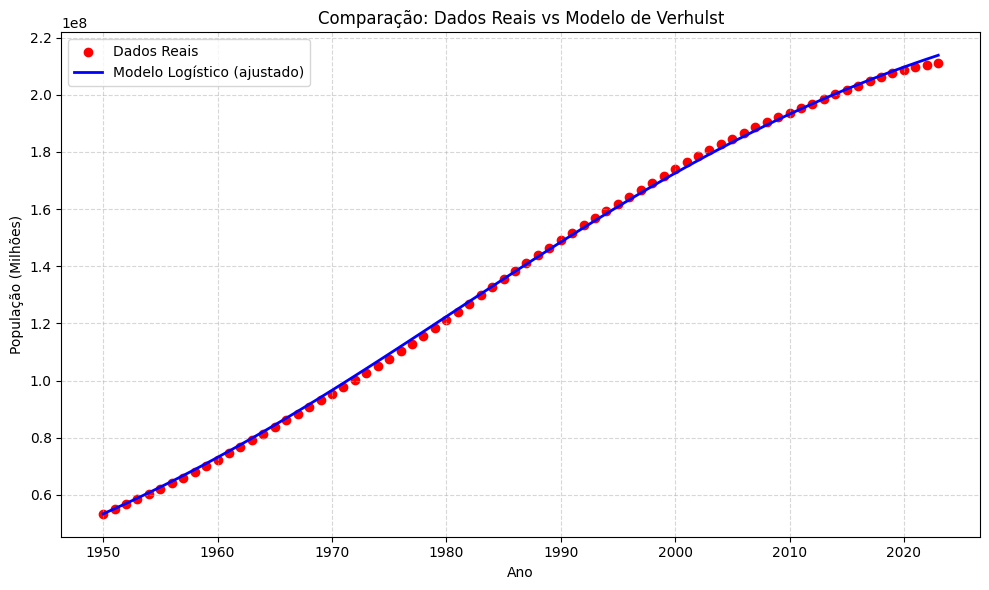

In [15]:
# Plotando os dados reais e o modelo de Verhulst
plt.figure(figsize=(10,6))
plt.scatter(anos, populacao_real, color='red', label='Dados Reais')
plt.plot(anos, populacao_verhulst, color='blue', label='Modelo Logístico (ajustado)', linewidth=2)


plt.title('Comparação: Dados Reais vs Modelo de Verhulst')
plt.xlabel('Ano')
plt.ylabel('População (Milhões)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# Comparando os dois modelos
Para complementar a análise visual e determinar com maior rigor qual modelo se ajusta melhor aos dados, foi realizada uma avaliação quantitativa da performance de cada um. Para isso, foram calculadas três métricas estatísticas padrão: o Coeficiente de Determinação ($R^2$), que mede o quão bem o modelo explica a variação dos dados reais; o Erro Quadrático Médio (MSE), que quantifica o erro total; e a Raiz do Erro Quadrático Médio (RMSE), que traduz esse erro para a mesma unidade da população (habitantes), tornando-o mais interpretável.

In [16]:
# Calcular o R² para cada modelo
r2_malthus = r2_score(populacao_real, populacao_malthus)
r2_verhulst = r2_score(populacao_real, populacao_verhulst)

# Calcular o MSE para cada modelo
mse_malthus = mean_squared_error(populacao_real, populacao_malthus)
mse_verhulst = mean_squared_error(populacao_real, populacao_verhulst)
rmse_malthus = np.sqrt(mse_malthus)
rmse_verhulst = np.sqrt(mse_verhulst)

print(f"Análise do Modelo de Malthus:")
print(f"  - R²: {r2_malthus:.4f}")
print(f"  - Erro Quadrático Médio (MSE): {mse_malthus:,.2f}")
print(f"  - Raiz do Erro Quadrático Médio (RMSE): {rmse_malthus:,.2f} habitantes\n")

print(f"Análise do Modelo Logístico:")
print(f"  - R²: {r2_verhulst:.4f}")
print(f"  - Erro Quadrático Médio (MSE): {mse_verhulst:,.2f}")
print(f"  - Raiz do Erro Quadrático Médio (RMSE): {rmse_verhulst:,.2f} habitantes")

print(f"\nO modelo logístico parece se ajustar melhor, com um R² mais próximo de 1 e menor MSE.")

Análise do Modelo de Malthus:
  - R²: 0.8799
  - Erro Quadrático Médio (MSE): 305,084,759,423,511.75
  - Raiz do Erro Quadrático Médio (RMSE): 17,466,675.68 habitantes

Análise do Modelo Logístico:
  - R²: 0.9996
  - Erro Quadrático Médio (MSE): 1,077,519,920,458.84
  - Raiz do Erro Quadrático Médio (RMSE): 1,038,036.57 habitantes

O modelo logístico parece se ajustar melhor, com um R² mais próximo de 1 e menor MSE.


# Usando o modelo para prever o crescimento da população brasileira até 2050
Uma vez estabelecida a superioridade do modelo logístico na descrição dos dados históricos, a análise prossegue com a aplicação de ambos os modelos para a projeção do crescimento futuro da população. Com essa finalidade, foi definido um horizonte temporal estendido até o ano de 2050. As equações de Malthus e Verhulst, utilizando os parâmetros previamente calculados, foram então empregadas para estimar o tamanho da população para cada ano nesse período futuro.

In [17]:
# Criar um array de anos futuros para a projeção
anos_futuros = np.arange(anos.min(), 2051) # Projetando até 2050

# Fazer a previsão com os modelos ajustados
projecao_malthus = modelo_malthus(anos_futuros, k_estimado, populacao_inicial)
projecao_verhulst = modelo_logistico(anos_futuros, k, K, populacao_inicial)

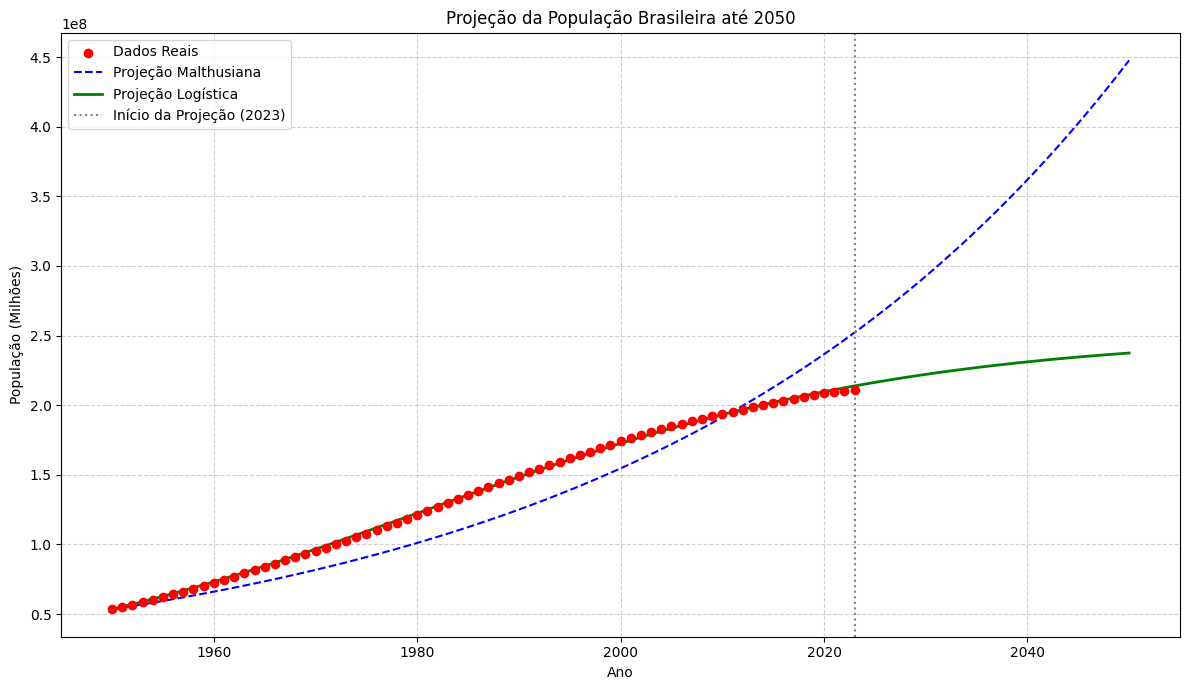


O modelo malthusiano prevê que a população brasileira em 2050 será de: 447,706,988

O modelo logístico prevê que a população brasileira em 2050 será de: 237,444,266


In [18]:
# Plotar o gráfico com as projeções
plt.figure(figsize=(12, 7))
plt.scatter(anos, populacao_real, color='red', label='Dados Reais', zorder=5)
plt.plot(anos_futuros, projecao_malthus, color='blue', linestyle='--', label='Projeção Malthusiana')
plt.plot(anos_futuros, projecao_verhulst, color='green', linewidth=2, label='Projeção Logística')

# Adicionar uma linha vertical para marcar o início da projeção
plt.axvline(x=anos.max(), color='gray', linestyle=':', label=f'Início da Projeção ({anos.max()})')

plt.title('Projeção da População Brasileira até 2050')
plt.xlabel('Ano')
plt.ylabel('População (Milhões)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Previsão da população em 2050
print(f'\nO modelo malthusiano prevê que a população brasileira em 2050 será de: {projecao_malthus[-1]:,.0f}')
print(f'\nO modelo logístico prevê que a população brasileira em 2050 será de: {projecao_verhulst[-1]:,.0f}')

# Conclusão
A análise mostrou que o modelo Logístico de Verhulst descreve o crescimento da população brasileira de forma muito mais precisa que o modelo Exponencial de Malthus. Isso foi observado tanto no gráfico, onde a curva do modelo logístico acompanha melhor os dados reais, quanto em métricas como o Coeficiente de Determinação ($R^2$) e a Raiz do Erro Quadrático Médio (RMSE), que indicaram um ajuste superior. O resultado sugere que a população do Brasil não cresce de forma acelerada e sem limites, mas segue um padrão que desacelera e tende a um valor máximo.

A projeção feita com o modelo logístico para o ano de 2050 estimou uma população de 237 milhões de habitantes. Esse número é muito próximo do valor projetado pela ONU para o mesmo ano (233 milhões), representando uma diferença de menos de 2%. Essa proximidade confirma que o modelo logístico, conforme aplicado neste estudo, foi uma ferramenta eficaz para entender e prever a dinâmica da população brasileira.